**Autor: Alexandre Esposte Santos**

Para esta análise escolheu-se o conjunto de dados dos <a href = https://www.kaggle.com/datasets/marcosfnlr/acidentes-em-rodovias-federais-20072020> acidentes em rodovias federais de 2007 a 2020</a>.

Pretende-se com essa análise obter um maior compreendimento dos acidentes em rodoviais federais do Brasil. Como objetivos primários podemos listar,

<ul>

<li> Distribuição de acidentes pelos dias da semana    
<li> O período do dia tem alguma influência nos acidentes?
<li> Como a condição meteorologica está relacionada com os acidentes?
<li> Existe alguma região cuja a quantidade de acidentes é discrepante quando comparada às outras?
<li> E com relação às rodovias? Há alguma com uma quantidade substâncial de acidentes?
<li> Com relação ao tipo do acidente, qual é o mais fatal?
<li> Quais os principais motivos dos acidentes?
<li> Há alguma relação entre a infraestrutura da pista e a quantidade de acidentes?
    
    
</ul>

In [2]:
# Importando os pacotes necessários para a análise

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.express as px

plt.style.use('default')

plt.style.use('seaborn-ticks')

cor = '#0000CD'

Lendo o conjunto de dados

In [3]:
# Lendo o dataset

df_raw = pd.read_csv("acidentes2007-2020.csv",sep=',',low_memory=False)
df_raw.head(3)

,Unnamed: 0,id,id_unico,dia_semana,horario,uf,br,km,municipio,causa_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,0,10,102007-06-11,segunda,15:30:00,MG,381,623.2,OLIVEIRA,falta de atenção,...,0,5,0,4,6,NaN,NaN,NaN,NaN,NaN
1,1,1032898,10328982007-08-13,segunda,14:25:00,MG,40,585.5,ITABIRITO,outras,...,1,2,0,1,1,NaN,NaN,NaN,NaN,NaN
2,2,1051130,10511302007-02-12,segunda,02:10:00,MA,135,11.0,SAO LUIS,animais na pista,...,1,0,0,3,1,NaN,NaN,NaN,NaN,NaN


In [4]:
# Verificando as colunas
df_raw.columns

Index(['Unnamed: 0', 'id', 'id_unico', 'dia_semana', 'horario', 'uf', 'br',
       'km', 'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional',
       'delegacia', 'uop'],
      dtype='object')

Observa-se que algumas colunas não nos servira de muita coisa e por isso serão removidas. As mesmas estão listadas abaixo junto com seus respectivos motivos,

<ul>
    
<li> 'Unnamed: 0': Essa coluna é simplesmente uma contagem e por isso será removida
   
<li> As colunas 'delegacia' e 'uop' estão trocadas e em uma primeira análise não nos servirá de muita coisa visto que está relacionada as unidades operacionais de polícia e as delegacias que atenderam ao acidente.
    
<li> 'latitude' e 'longitude' serão removidas pois já temos outras colunas que nos informa a localidade dos acidentes. Essas colunas seriam interessantes para uma visualização junto ao maps.
    
<li> A coluna 'regional' será removida devido que já temos outras colunas que informa a região.
    
<li> Por último, removeremos a coluna 'horário' uma vez que podemos utilizar a coluna fase_dia para determinar em qual período do dia houveram mais acidentes. 
    
    
</ul>    

In [5]:
colunas_remover = ['Unnamed: 0','delegacia','uop','latitude','longitude','regional','horario']

df_acidentes = df_raw.drop(columns=colunas_remover, axis=1)

Agora verificaremos se há regisros duplicados

In [5]:
print(f'Registros duplicados: {df_acidentes.duplicated().sum()}')

Registros duplicados: 0


Uma observação interessante está nas colunas 'id' e 'id_unico'. Observa-se que a coluna 'id_unico' é composta por dois valores, sendo o primeiro o valor da coluna 'id' e o segundo a data do acidente.

Vamos tratar a coluna 'id_unico' para assim termos em mãos a data do acidente

In [6]:
# Verificando o tipo das colunas id e id_unico
print(f"----Tipo----\n{df_acidentes[['id','id_unico']].dtypes}\n")


#Verificando se existe valor faltante
print(f"----Valores faltantes----\n{df_acidentes[['id','id_unico']].isna().sum()}")




----Tipo----
id           int64
id_unico    object
dtype: object

----Valores faltantes----
id          0
id_unico    0
dtype: int64


In [7]:
#Vamos mudar o tipo da coluna id para object(string)
df_acidentes = df_acidentes.astype({"id":str})

# vamos remover os valores da coluna "id" da coluna "id_unico" com o método replace
for ind,val in enumerate(df_acidentes['id']):
    df_acidentes.loc[ind,'id_unico'] = df_acidentes.loc[ind,'id_unico'].replace(val,'',1)
    
#Agora vamos remover a coluna id e renomear a coluna id_unico para data
df_acidentes.drop(columns=['id'],axis=1,inplace=True)

df_acidentes = df_acidentes.rename(columns={"id_unico": 'data'})

df_acidentes.head(1)

,data,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,...,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos
0,2007-06-11,segunda,MG,381,623.2,OLIVEIRA,falta de atenção,Colisão Frontal,NaN,Pleno dia,...,Reta,Rural,9,0,4,0,5,0,4,6


In [8]:
#Agora vamos mudar o tipo da variavel data para datetime
df_acidentes['data'] = pd.to_datetime(df_acidentes['data'],format='%Y-%m-%d')

# Vamos criar uma coluna apenas com o ano para facilitar em uma futura filtragem
df_acidentes['ano'] = df_acidentes['data'].dt.year

df_acidentes.head(3)

,data,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,...,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,ano
0,2007-06-11,segunda,MG,381,623.2,OLIVEIRA,falta de atenção,Colisão Frontal,NaN,Pleno dia,...,Rural,9,0,4,0,5,0,4,6,2007
1,2007-08-13,segunda,MG,40,585.5,ITABIRITO,outras,Saída de Pista,Com Vítimas Feridas,Pleno dia,...,Rural,3,0,0,1,2,0,1,1,2007
2,2007-02-12,segunda,MA,135,11.0,SAO LUIS,animais na pista,Atropelamento de Animal,Com Vítimas Fatais,Plena noite,...,Urbano,5,2,2,1,0,0,3,1,2007


# Análise

### **Observa-se o crescimento na quantidade de acidentes no intervalo de 2007 a 2011. Após 2011 observamos a queda dos acidentes até 2020, tendo um aumento em 2013**

In [9]:
df_acidentes.groupby('ano')['ano'].count()

ano
2007    127671
2008    141038
2009    158646
2010    183465
2011    192322
2012    184561
2013    186745
2014    169197
2015    122158
2016     96362
2017     89518
2018     69206
2019     67446
2020     63530
Name: ano, dtype: int64

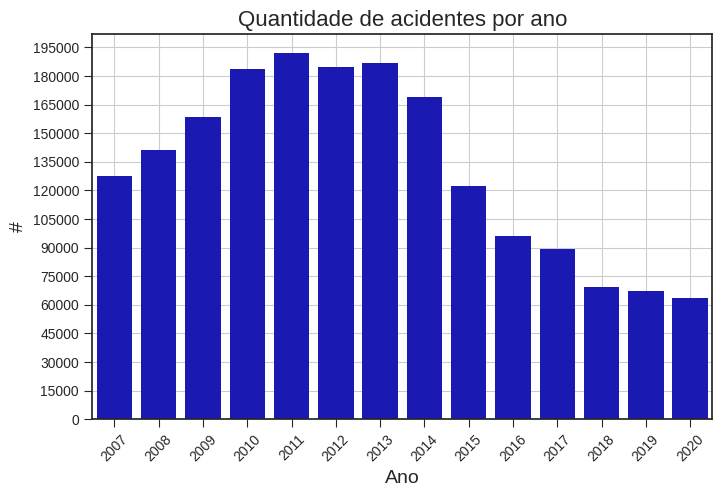

In [10]:
plt.figure(figsize=(8,5));
plt.title("Quantidade de acidentes por ano",fontsize=16);

sns.countplot(data = df_acidentes, x='ano',color=cor);

plt.xticks(rotation=45);
plt.yticks(ticks=range(0,200000,15000))

plt.xlabel('Ano',fontsize=14);
plt.ylabel("#",fontsize=14);
plt.grid()

### Observamos uma sazonalidade nos dias da semana. De 2007 a 2015 temos que a sexta-feira foi o dia da semana com mais acidentes, e de 2016 a 2020 tivemos alguns anos com sábado e outros o domingo com o pico de acidentes. 

### Conclui-se que grande parte dos acidentes ocorreram aos finais de semana !

In [11]:
# Verificando valores nulos na coluna dia_semana
print(f"Valores nulos na coluna dias_semana: {df_acidentes['dia_semana'].isna().sum()}")

Valores nulos na coluna dias_semana: 0


In [12]:
# Criando uma coluna para auxiliar no pivot_table
df_acidentes['auxiliar'] = 0

# Aqui temos um Dataframe separado com todas as contagens em todos os anos
aux = pd.pivot_table(df_acidentes,index='dia_semana',columns='ano',values='auxiliar',aggfunc=len)

aux

ano,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
dia_semana,,,,,,,,,,,,,,
domingo,20302,20670,22728,26682,28352,27179,26519,24248,18614,15562,14779,11265,11298,10416
quarta,16281,18913,20834,24443,25145,24243,24831,22637,16081,12109,11018,8814,8374,8152
quinta,17202,19040,22198,25165,26389,25555,25846,23300,16963,12773,11783,9217,8755,8241
segunda,16926,18811,21877,25434,26571,25503,26318,23604,17061,12914,12170,9410,9134,8518
sexta,20580,23221,26077,30182,30800,30826,30884,27883,18995,15088,13842,10624,10381,9763
sábado,20464,22338,24645,28256,30337,27925,28007,25799,19047,16261,15166,11227,11099,10663
terça,15916,18045,20287,23303,24728,23330,24340,21726,15397,11655,10760,8649,8405,7777


In [13]:
aux.columns = aux.columns.astype('str')

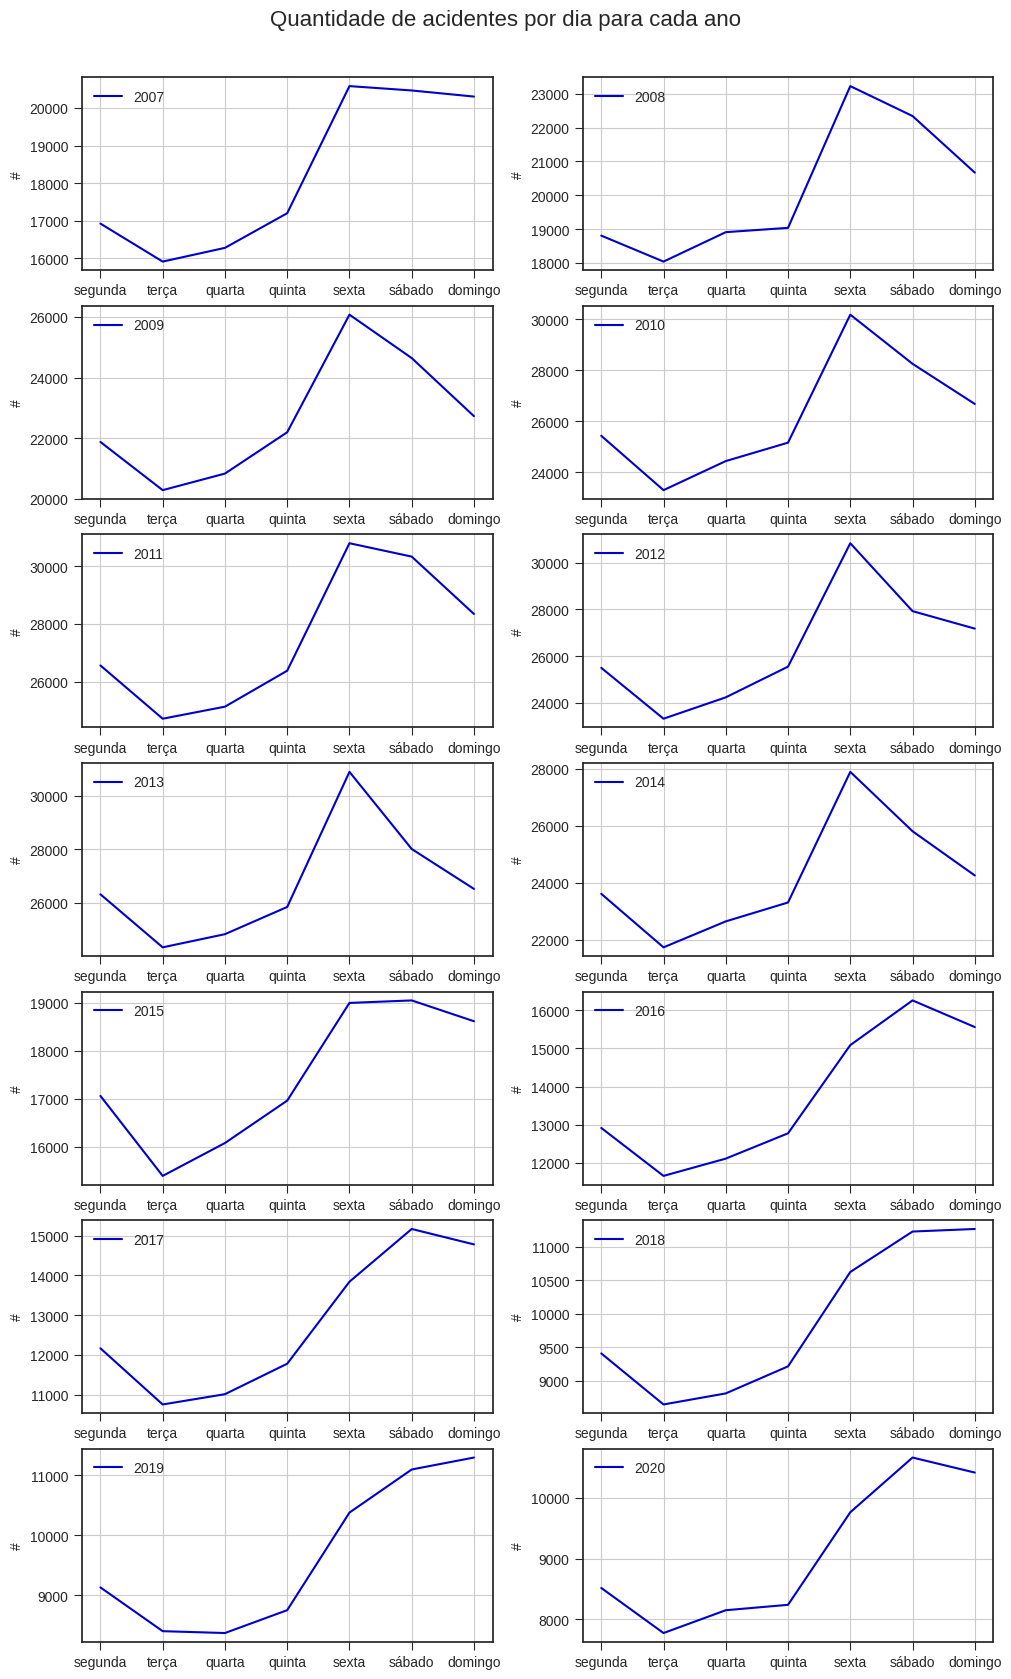

In [14]:
fig, ax = plt.subplots(nrows = 7,ncols=2,figsize=(10,16),constrained_layout=True);

fig.suptitle("Quantidade de acidentes por dia para cada ano",fontsize=16,y = 1.04)

ex = ['segunda','terça','quarta','quinta','sexta','sábado','domingo']

ano = 2007
for linha in range(7):
    for coluna in range(2):
        ey = [aux.loc[dia,str(ano)] for dia in ex]
        sns.lineplot(ax=ax[linha,coluna],x=ex,y=ey,label=f'{ano}',color=cor)
        ax[linha,coluna].legend(loc=2,bbox_to_anchor=(0,1))
        ax[linha,coluna].set_ylabel("#")
        #ax[linha,coluna].set_title(f"{ano}")
        ax[linha,coluna].grid()
        ano+=1
